In [1]:
import time
import numpy as np
from numba import typed
from pyloki.simulation.pulse import PulseSignalConfig
from pyloki.config import PulsarSearchConfig
from pyloki.ffa import DynamicProgramming
from pyloki.periodogram import Periodogram
from pyloki.detection import scoring
from pyloki.utils import np_utils
from matplotlib import pyplot as plt

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


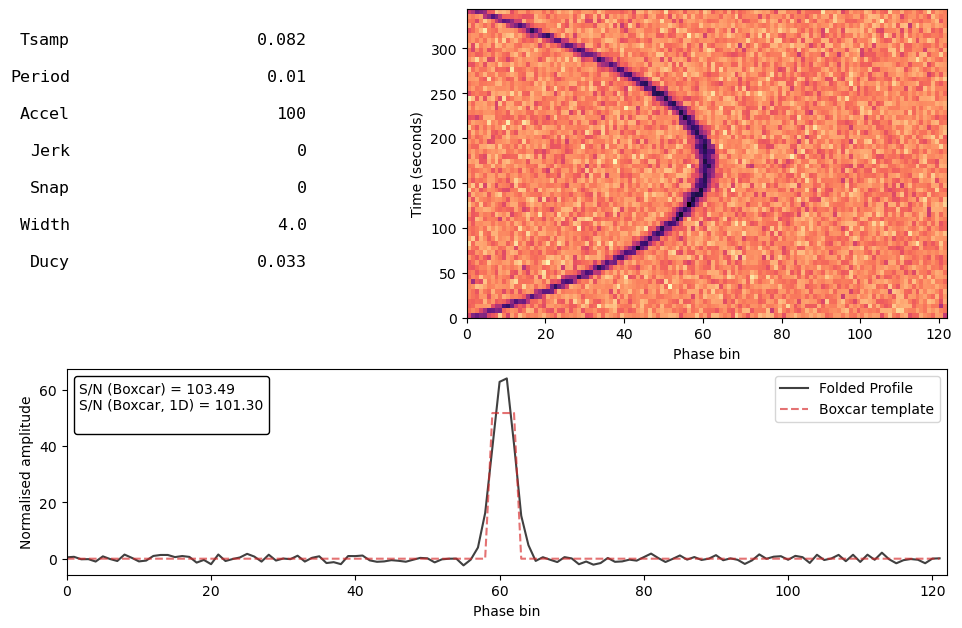

In [2]:
pulsar_period = 0.01
dt = 8.192e-5
accel = 100
nsamps = 2**22
mod_kwargs = {"acc": accel}

cfg = PulseSignalConfig(period=pulsar_period, dt=dt, nsamps=nsamps, snr=100, ducy=0.05, mod_kwargs=mod_kwargs)
tim_data = cfg.generate(shape="gaussian")
tim_data.plot_fold(cfg.freq, cfg.fold_bins, mod_kwargs=mod_kwargs); plt.show()

In [3]:
ephem_fold = tim_data.fold_ephem(cfg.freq, cfg.fold_bins, mod_kwargs=mod_kwargs)

In [4]:
from sigpyproc.core import filters as sig_filters

In [5]:
sig_boxcar = sig_filters.MatchedFilter(ephem_fold, loc_method="norm", scale_method="norm", nbins_max=20, spacing_factor=1.2, temp_kind="gaussian")

In [6]:
sig_boxcar.snr

np.float64(105.6353517979202)

In [7]:
tol_bins = cfg.tol_bins
fold_bins = cfg.fold_bins_ideal

tol_bins = 2
param_limits = typed.List([(90.0, 110.0), (1/0.011, 1/0.009)])
search_cfg = PulsarSearchConfig(cfg.nsamps, cfg.dt, fold_bins, tol_bins, param_limits)
dyp = DynamicProgramming(tim_data, search_cfg)
dyp.initialize()
dyp.execute()

2024-09-04 14:08:28 INFO     - pyloki.ffa - Initializing data structure...

                    INFO     - pyloki.ffa - param steps: [3.49004355e+06 5.02028105e-02]

2024-09-04 14:08:30 INFO     - pyloki.ffa - fold dimensions: (1024, 1, 402, 2, 122)

2024-09-04 14:08:31 INFO     - pyloki.ffa - Initialization time: 2.596856117248535

                    INFO     - pyloki.ffa - param steps: [8.72510887e+05 2.47601932e-02]

2024-09-04 14:08:32 INFO     - pyloki.ffa - iteration: 1, fold dimensions: (512, 1, 815, 2, 122)

                    INFO     - pyloki.ffa - param steps: [2.18127722e+05 1.22965212e-02]

2024-09-04 14:08:33 INFO     - pyloki.ffa - iteration: 2, fold dimensions: (256, 1, 1642, 2, 122)

                    INFO     - pyloki.ffa - param steps: [5.45319304e+04 6.12757758e-03]

                    INFO     - pyloki.ffa - iteration: 3, fold dimensions: (128, 1, 3296, 2, 122)

                    INFO     - pyloki.ffa - param steps: [1.36329826e+04 3.05864409e-03]

                    INFO     - pyloki.ffa - iteration: 4, fold dimensions: (64, 1, 6604, 2, 122)

                    INFO     - pyloki.ffa - param steps: [3.40824565e+03 1.52803911e-03]

                    INFO     - pyloki.ffa - iteration: 5, fold dimensions: (32, 1, 13220, 2, 122)

                    INFO     - pyloki.ffa - param steps: [8.52061413e+02 7.63699222e-04]

                    INFO     - pyloki.ffa - iteration: 6, fold dimensions: (16, 1, 26452, 2, 122)

                    INFO     - pyloki.ffa - param steps: [2.13015353e+02 3.81769579e-04]

                    INFO     - pyloki.ffa - iteration: 7, fold dimensions: (8, 1, 52916, 2, 122)

                    INFO     - pyloki.ffa - param steps: [5.32538383e+01 1.90864788e-04]

                    INFO     - pyloki.ffa - iteration: 8, fold dimensions: (4, 1, 105844, 2, 122)

                    INFO     - pyloki.ffa - param steps: [1.33134596e+01 9.54273941e-05]

2024-09-04 14:08:34 INFO     - pyloki.ffa - iteration: 9, fold dimensions: (2, 1, 211700, 2, 122)

                    INFO     - pyloki.ffa - param steps: [3.32836489e+00 4.77124472e-05]

2024-09-04 14:08:39 INFO     - pyloki.ffa - iteration: 10, fold dimensions: (1, 6, 423411, 2, 122)

In [8]:
folds = dyp.get_fold_norm()
widths = scoring.generate_width_trials(dyp.nbins, ducy_max=0.5, wtsp=1)
snrs = scoring.boxcar_snr(folds, widths)
pgram = Periodogram(params={"width": widths, "freq": dyp.param_arr[-1], "accel": dyp.param_arr[-2]}, snrs=snrs, tobs=tim_data.tobs)
print(pgram.find_best_indices())
print(pgram.get_summary())
#print(f"expected width = {cfg.ducy * cfg.period / cfg.dt / cfg.fold_bins}")

(np.int64(1), np.int64(190545), np.int64(6))
Best S/N: 75.80
Best Period: 0.01
Best accel: 95.71428571428571
Best freq: 100.00050575187795
Best width: 7


In [9]:
idx_per = np_utils.find_nearest_sorted_idx(dyp.param_arr[-1], cfg.freq)
idx_acc = np_utils.find_nearest_sorted_idx(dyp.param_arr[-2], cfg.mod_kwargs["acc"])
true_params_idx = (idx_acc, idx_per)

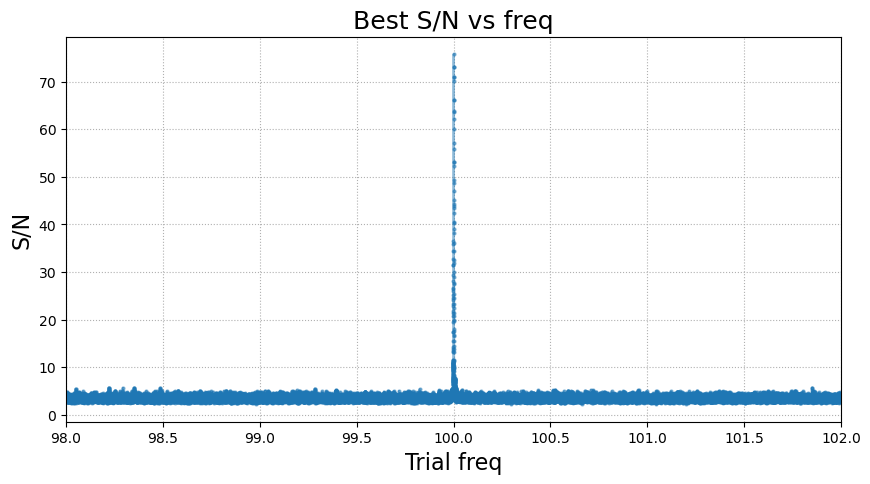

In [10]:
fig = pgram.plot_1d("freq", x_lim=(98, 102), figsize=(10, 5)); plt.show()

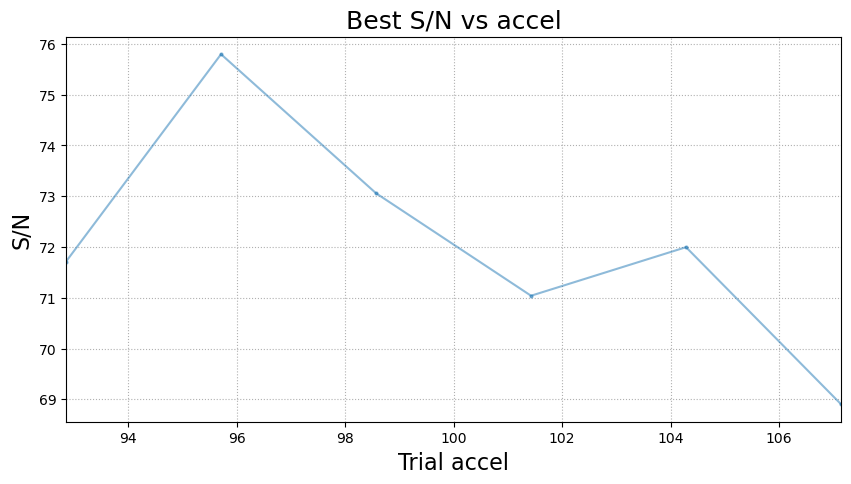

In [11]:
fig = pgram.plot_1d("accel", figsize=(10, 5)); plt.show()

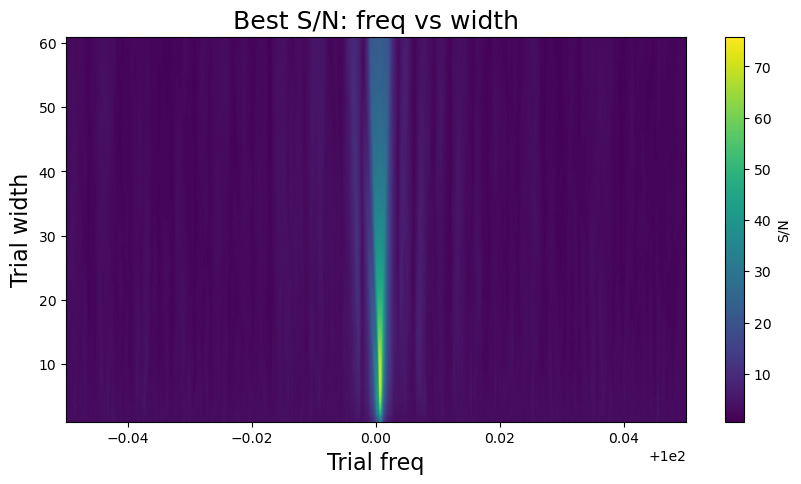

In [12]:
fig = pgram.plot_2d("freq", "width", x_lim=(99.95, 100.05), figsize=(10, 5)); plt.show()